# Test des méthodes de taguage - Catégorisez automatiquement des questions

## Introduction 

Nous avons dans une précédente partie étudier un dataset composée de questions issus du site stck overflows. les questions sont composées de titre, du corps de la question et de tags. Nous avons dans un premier temps effectuer un plongement de mots pour représenté notre texte via une matrice de type bag of words. A noter que nous n'avons retenus que les 600 mots les plus utilisées de notre vocabulaire.

Nous allons essayer dans cette partie de nous concentrer sur l'automatisation du taggage: essayer de générer de manière automatique des tags liés à la question. 

## Approche non supervisée

Nous allons tout d'abord essayer de taguer nos questions de manière non supervisées. Nous allons utilisés la matrice précédement généré et nous allons utilisé l'algorithme de Dirichlet: 'Latent Dirichlet Allocation'. Cette algorithme va nous permettre de générer des sujets composées de mots.

In [3]:
import pandas as pd
BOW = pd.read_csv('BOW.csv')
BOW = BOW.drop('Unnamed: 0', 1)

Pour trouver l'algorithme le plus performant, nous allons effectuer un gridsearch sur le nombre de topics. Cette opération peut durer assez longtemps

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
lda = LatentDirichletAllocation(learning_method='online', n_jobs=-1)

search_params = {'n_topics': [5, 6 ,7, 8, 9, 10, 11, 12, 15, 18, 20, 30, 50, 75, 100]}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(BOW.values)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=-1, n_topics=10, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 20, 30, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
lda_best = model.best_estimator_
lda_best.get_params

<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=-1, n_topics=5, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)>

Pour comparer ces modèles nous allons utilisés une mesure: log likelihood

c:\users\zakis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


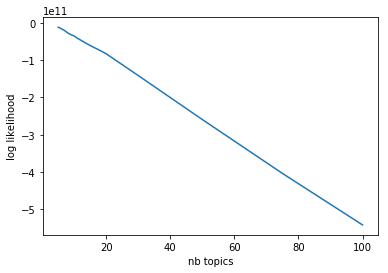

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
n_topics = [5, 6 ,7, 8, 9, 10, 11, 12, 15, 18, 20, 30, 50, 75, 100]
log_likelyhoods = [round(gscore.mean_validation_score) for gscore in model.grid_scores_]
plt.plot(n_topics, log_likelyhoods)
plt.xlabel('nb topics')
plt.ylabel('log likelihood')

On voit que le nombre de topics optimal est 5, ce qui semble peut pour expliquer tous nos documents. Regardons de plus près qu'elles sont ces topics.

In [ ]:
lda_best = LatentDirichletAllocation(learning_method='online', n_jobs=-1, nb_topics=5)
lda_best.fit(BOW.values)

Nous allons pour cela essayer d'afficher les 10 mots les plus probables par topics pour avoir une idée du sujet en question.

In [34]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda_best.n_topics)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_best.components_)

# Assign Column and Index
df_topic_keywords.columns = BOW.columns
df_topic_keywords.index = topicnames

import numpy as np
x = np.argsort(-df_topic_keywords.values, axis = 1)
y = np.asarray(df_topic_keywords.columns[x].tolist()).reshape((5,600)).astype(str)

In [36]:
print(y[:,:10])

[['thi' 'class' 'string' 'object' 'return' 'public' 'new' 'int' 'function'
  'method']
 ['file' 'java' 'error' 'system' 'server' 'run' 'window' 'thread' 'servic'
  'script']
 ['use' 'thi' 'would' 'like' 'ani' 'code' 'way' 'one' 'work' 'time']
 ['id' 'tabl' 'name' 'thi' 'select' 'valu' 'key' 'data' 'sql' 'databas']
 ['user' 'thi' 'page' 'use' 'control' 'html' 'form' 'http' 'view' 'net']]


On peut essayer de donner un intitulé à chacun de ces topics: 

1 - language orienté objet
2 - réseaux
3 - pas de sujet précis
4 - database
5 - front end, html, css...

Ces sujets sont censés nous donnés la base de nos quelques 200000 documents, ce qui nous semble être très peu, voyons comment il se comporte sur les premiers documents

In [6]:
df = pd.read_csv('Query.csv', encoding='latin-1')

In [39]:
print(df['Title'][0])
print(df['Body'][0])

While applying opacity to a form, should we use a decimal or a double value?
<p>I want to use a track-bar to change a form's opacity.</p>

<p>This is my code:</p>

<pre><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>

<p>When I build the application, it gives the following error:</p>

<blockquote>
  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>
</blockquote>

<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>



In [43]:
# Create Document - Topic Matrix
lda_output = lda_best.transform(BOW.values)

In [45]:
lda_output[0,:]

array([ 0.53665479,  0.00585954,  0.20443982,  0.00580943,  0.24723642])

On voit que la question est identifié plutôt identifié sur les topics: orientée objet et front end. 

Regardons un autre exemple:

In [46]:
print(df['Title'][1])
print(df['Body'][1])
print(lda_output[1,:])

Percentage width child element in absolutely positioned parent on Internet Explorer 7
<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href="http://en.wikipedia.org/wiki/Internet_Explorer_7" rel="noreferrer">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>

<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>

<ol>
<li>Is there something I'm missing here?</li>
<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the
child?</li>
<li>Is there an area of the CSS specification that covers this?</li>
</ol>

[ 0.00534982  0.00529059  0.00543081  0.97859047  0.0053383 ]


On a une question plutôt orienté front end et on voit que le taggage est uniquement orienté back end...

On peut en conclure que ce taguage n'est pas bon ici pour deux raisons: topics trop peu spécifiques, attribution des topics aux documents pas assez pertinent.

On peut essayer de voir lorsque l'on prend un nombre de sujets plus grand si on a la possiblité d'avoir un taging plus précis et plus pertinent.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
lda_best = LatentDirichletAllocation(learning_method='online', n_jobs=-1, n_topics=15)
lda_best.fit(BOW.values)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=-1, n_topics=15, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [6]:
# column names
topicnames = ["Topic" + str(i) for i in range(15)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_best.components_)

# Assign Column and Index
df_topic_keywords.columns = BOW.columns
df_topic_keywords.index = topicnames

import numpy as np
x = np.argsort(-df_topic_keywords.values, axis = 1)
y = np.asarray(df_topic_keywords.columns[x].tolist()).reshape((15,400)).astype(str)

In [7]:
print(y[:,:10])

[['thi' 'use' 'like' 'way' 'would' 'time' 'one' 'want' 'object' 'foo']
 ['page' 'control' 'html' 'view' 'javascript' 'asp' 'jqueri' 'style' 'load'
  'thi']
 ['use' 'thi' 'java' 'like' 'ani' 'would' 'code' 'know' 'doe' 'work']
 ['valu' 'id' 'tabl' 'select' 'name' 'key' 'thi' 'properti' 'queri'
  'column']
 ['file' 'line' 'script' 'div' 'thi' 'command' 'path' 'use' 'directori'
  'width']
 ['user' 'form' 'php' 'app' 'button' 'custom' 'input' 'browser' 'click'
  'action']
 ['name' 'type' 'code' 'url' 'includ' 'post' 'output' 'compil' 'search'
  'print']
 ['server' 'data' 'web' 'applic' 'servic' 'connect' 'use' 'databas'
  'client' 'net']
 ['python' 'xml' 'model' 'import' 'templat' 'node' 'context' 'td' 'parent'
  'pattern']
 ['text' 'string' 'array' 'imag' 'size' 'format' 'convert' 'tag' 'byte'
  'charact']
 ['test' 'project' 'build' 'version' 'sourc' 'instal' 'develop' 'android'
  'visual' 'tool']
 ['http' 'com' 'request' 'org' 'memori' 'lib' 'www' 'rubi' 'microsoft'
  'respons']
 ['class

On voit ici un peu plus de précision quant aux sujets abordées, cependant les sujets nous semblent encore trop vague pour pouvoir caractériser tous nos documents. Ils semblent donc que cette approche ne sera pas celle que l'on retiendra.

On voit cependant que notre représentation utilise les mots les plus fréquents. C'est potentiellement parce qu'on a entrainer notre algorithme sur une représentation tf. Nous allons maintenant étudiés une représentation tf-idf malgré ce qu'on a vu dans la précédente partie c'est à dire que la fréquence des documents n'apporte pas beaucoup d'informations

## Clustering avec une matrice tf-idf

On charge notre texte cleané (travail de la partie précédente).

In [51]:
import pandas as pd
df_tf_idf = pd.read_csv('tf_idf.csv')
values = df_tf_idf.values

In [65]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(values)

In [60]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, df_tf_idf.columns(), no_top_words)

Topic 0:
use thi would code like ani know time one way
Topic 1:
valu int list function array return type thi item error
Topic 2:
file directori line folder path open command read xml project
Topic 3:
tabl sql databas queri column select id row data server
Topic 4:
imag text html page div javascript jqueri button css form
Topic 5:
class public object method static name properti new void type
Topic 6:
string charact convert format public text char new thi match
Topic 7:
test unit run code write framework fail project build method
Topic 8:
java org eclips thread librari jar util com apach applic
Topic 9:
net applic asp web window server servic user control mvc


On retrouve approximativement les mêmes sujets que ceux abordés avec une représentation tf. On va donc maintenant se concentrer sur des méthodes supervisées.

## Taguage supervisé

On va dans un premier temps étudié les tags que nous renvoient la requête à stackexchange.


In [9]:
df['Tags'].head()

0    <c#><winforms><type-conversion><decimal><opacity>
1               <html><css><css3><internet-explorer-7>
2                                 <c#><.net><datetime>
3    <c#><datetime><time><datediff><relative-time-s...
4    <javascript><html><browser><timezone><timezone...
Name: Tags, dtype: object

Il va nous falloir séparer ces tags proprement.

In [7]:
tags = [t[1:len(t) - 1].split('><') for t in df['Tags']]

Nous allons essayer de limiter le nombre de tags pour ne pas les prendre en compte tous car l'attribution d'un tag va être de plus en plus difficile plus les tags ont une fréquence faible.

In [9]:
import numpy as np
words = []
for t in tags:
     words += t

from collections import Counter
freq_totale = Counter(words)
print(np.array(freq_totale.most_common(100)))

[['c#' '25400']
 ['java' '16706']
 ['.net' '14168']
 ['c++' '11169']
 ['python' '10136']
 ['javascript' '9156']
 ['php' '8324']
 ['asp.net' '6562']
 ['jquery' '5760']
 ['sql' '5546']
 ['iphone' '5406']
 ['c' '5269']
 ['html' '4553']
 ['sql-server' '4394']
 ['mysql' '3894']
 ['wpf' '3649']
 ['asp.net-mvc' '3525']
 ['ruby' '3381']
 ['windows' '3375']
 ['css' '3313']
 ['ruby-on-rails' '3297']
 ['objective-c' '3217']
 ['visual-studio' '2738']
 ['performance' '2686']
 ['linux' '2683']
 ['database' '2623']
 ['django' '2418']
 ['android' '2361']
 ['algorithm' '2327']
 ['string' '2307']
 ['xml' '2287']
 ['multithreading' '2287']
 ['winforms' '2213']
 ['regex' '2065']
 ['perl' '1965']
 ['svn' '1919']
 ['unit-testing' '1891']
 ['eclipse' '1850']
 ['git' '1751']
 ['arrays' '1733']
 ['linq' '1716']
 ['visual-studio-2008' '1652']
 ['delphi' '1643']
 ['vb.net' '1586']
 ['cocoa' '1548']
 ['cocoa-touch' '1534']
 ['macos' '1528']
 ['oop' '1527']
 ['debugging' '1501']
 ['language-agnostic' '1499']
 ['se

Nous avons décidé de ne garder que les 50 premiers tags les plus fréquents pour limiter les calculs que l'on va engendrer avec nos algorithmes de classifications. De plus, nous souhaitons proposer un taguage pour des utilisateurs nouveaux, l'esprit de cette démarche est d'orienter l'utilisateur pour qu'ils comprennent le fonctionnement du site, il parait donc inutile de proposer un taguage trop précis qui va engendrer des erreurs trop importantes.

In [10]:
mostcommon = np.array(freq_totale.most_common(50))

#removing the common words from tags
final_tags = []
for ts in tags:
    final_tags.append([word for word in ts if word in mostcommon])
final_tags = np.array(final_tags)

On retire de notre liste de tags les tags les plus utilisés

In [11]:
#removing the empty lists of tags  
# argument where the list of tags is not empty
arg_is_empty = np.array([i for i in range(0, len(final_tags)) if not final_tags[i]]).astype(int)
#array of boolean to keep non empty values
is_not_empty = ~np.in1d(np.arange(0, len(final_tags)), arg_is_empty)
final_tags = final_tags[is_not_empty]
BOW = BOW[is_not_empty]        

length = len(sorted(final_tags,key=len, reverse=True)[0])
y=np.array([xi+[None]*(length-len(xi)) for xi in final_tags])
x = pd.DataFrame(y)

In [13]:
x.to_csv('tags_cleaned.csv')
BOW.to_csv('BOW_final.csv')

Nous allons préparer notre sortie et séparer les donner de tests et d'entrainement.

In [1]:
import pandas as pd
tags = pd.read_csv('tags_cleaned.csv')
tags = tags.drop('Unnamed: 0', 1)
BOW = pd.read_csv('BOW_final.csv')
BOW = BOW.drop('Unnamed: 0', 1)

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer().fit(tags.values.astype(str))
y = multilabel_binarizer.transform(tags.values.astype(str))

In [3]:
import numpy as np
y = np.delete(y, 29, 1) 

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(BOW.values, y, test_size=0.2, random_state=0)

C:\Users\zakis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Logistic Regression

Nos tags sont prêts pour l'entrainement supervisé. Il nous faut choisir maintenant la famille d'algorithme que nous allons utilisés. On rappelle que notre problème est un problème de classification supervisée avec une sortie multiple. Nous allons tout d'abord essayer l'algorithme qui nous semble le plus simple (linéaire) et qui est la LogisticRegression. 

Comme notre algorithme ne peut classifier avec une sortie multiple, nous allons utilisés un label binarizer qui va nous permettre d'entrainer notre algorithme sur chacune des sorties.

In [5]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = BinaryRelevance(LogisticRegression(n_jobs=5))
classifier.fit(X_train, y_train)

#estimate the best predicted tags
y_pred_lr = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))

0.276642237612


Sans essayer de vouloir tout de suite estimer la capacité de cet algorithme à prévoir des tags, on peut tout de suite noter que cette méthode demande des calculs conséquents: on va devoir effectuer une classification par tag. 

Nous allons donc maintenant observer le fonctionnement d'algorithmes qui sont adaptés à la classification à sortie multiple.

#### Classifieur K voisins

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc = knc.fit(X_train, y_train)

#estimate the best predicted tags
y_pred = knc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.169636253614


#### ExtraTreesClassifier

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
extra_trees = ExtraTreesClassifier(n_estimators=50)
extra_trees = extra_trees.fit(X_train, y_train)

#estimate the best predicted tags
y_pred_extra_trees = extra_trees.predict(X_test)
print(accuracy_score(y_test, y_pred_extra_trees))

0.217676326229


#### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=50)
forest = forest.fit(X_train, y_train)

#estimate the best predicted tags
y_pred_forest = forest.predict(X_test)
print(accuracy_score(y_test, y_pred_forest))

0.306528608889


On voit que ces algorithmes sans optimisation présentent le fait que le random forest et la régression logistique sont les deux algorithmes sur lesquels nous allons vouloir concentrer nos efforts.

## Optimisation Random Forest

Nous allons tout d'abord observer les résultats et essayer de comprendre qu'elles sont les erreurs engendrées par notre algorithme.

In [47]:
tags_pred = multilabel_binarizer.inverse_transform(np.concatenate([y_pred[:,:29], 0*np.ones((len(y_pred), 1)), y_pred[:,29:]], axis=1))
tags_test = multilabel_binarizer.inverse_transform(np.concatenate([y_test[:,:29], 0*np.ones((len(y_test), 1)), y_test[:,29:]], axis=1))

In [48]:
print(tags_test[0])
print(tags_pred[0])

('delphi',)
()


In [10]:
print(tags_test[1])
print(tags_pred[1])

('sql-server',)
('sql-server',)


In [11]:
print(tags_test[2])
print(tags_pred[2])

('asp.net-mvc', 'c#')
()


In [12]:
print(tags_test[3])
print(tags_pred[3])

('mysql',)
('mysql',)


In [13]:
print(tags_test[4])
print(tags_pred[4])

('database',)
('java',)


In [14]:
print(tags_test[5])
print(tags_pred[5])

('python',)
('python',)


Après avoir observé les premières occurences de notre algorithme, on observe un premier problème celui des prédictions nulles: lorsque l'algorithme n'arrive à prédire aucun tag.

On décide d'essayer de voir quels peuvent être les influences d'un mauvais taguages pour un random forest.

On peut essayer de voir les questions sur lesquels notre algorithme s'est trompé.

In [49]:
import pickle 

infile = open("clean_train_reviews.pyc",'rb')
clean_train_reviews = pickle.load(infile)
infile.close()

In [50]:
print(clean_train_reviews[2])
print(tags_test[2])
print(tags_pred[2])

calcul someon age c given datetim repres person birthday calcul age year
('asp.net-mvc', 'c#')
()


In [51]:
i = 4
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

determin user timezon ani standard way web server abl determin user timezon within web page perhap http header part user agent string
('database',)
('java',)


In [57]:
i = 15
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

multipl submit button html form let say creat wizard html form one button goe back one goe forward sinc back button appear first markup press enter use button submit form exampl form put cursor thi field press enter input type text name field thi button submit input type submit name prev valu previou page thi button want submit input type submit name next valu next page form would like get decid button use submit form user press enter way press enter wizard move next page previou use tabindex thi
('c',)
()


In [61]:
i = 18
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

page collect linq page collect linq given startindex count
('ruby', 'ruby-on-rails')
()


In [65]:
i = 20
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

get subclips aptana work newest releas subvers version subclips current avail aptana automat plugin manag doe work newest version subvers see subclips websit howev eclips ad new remot updat site updat manag tri instal told need mylyn much search found mylyn ad anoth new remot updat site updat manag tri instal told need org eclips ui equival look configur detail aptana look like built eclips doe anyon know way upgrad version eclips aptana built way get subclips work veri newest version subvers know thi necessarili program question hope ok sinc highli relev program experi
('.net', 'c#')
()


In [69]:
i = 24
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

branch merg tortoisesvn branch merg apach subvers use tortoisesvn client
('winforms',)
()


**Remarque:** On va considérer que si les tags prédits correspondent à une partie des tags tests, la réponse est correct comme dans cette exemple:

In [71]:
i = 22
print(clean_train_reviews[i])
print(tags_test[i])
print(tags_pred[i])

flat file databas best practic around creat flat file databas structur php lot matur php flat file framework see attempt implement sql like queri syntax top purpos case would use databas point ani eleg trick get good perform featur small code overhead one would want take thi problem first place
('mysql', 'php', 'sql')
('mysql',)


Pour les erreurs observées plus haut on peut remarquer que plus le nombre de mots de la question est faible, plus le taguage est susceptible d'être faux.

In [7]:
x = np.concatenate([y_pred[:,:29], 0*np.ones((len(y_pred), 1)), y_pred[:,29:]], axis=1)
tags_pred = multilabel_binarizer.inverse_transform(np.array(x))
x = np.concatenate([y_test[:,:29], 0*np.ones((len(y_test), 1)), y_test[:,29:]], axis=1)
tags_test = multilabel_binarizer.inverse_transform(np.array(x))

from collections import defaultdict
tags_values = defaultdict(int)
for i in range(0, len(tags_test)):
    if len(tags_pred[i]) == 0:
        tags_values[i] = -1
    else:
        for tag in tags_pred[i]:
            if tag in tags_test[i]:
                tags_values[i] = 1
            else:
                tags_values[i] = 0
                break
                
x =  np.array(list(tags_values.values()))
keys =  np.array(list(tags_values.keys()))
TRUE_TAGS_ARG = keys[x == 1]
FALSE_TAGS_ARG = keys[x == 0]
EMPTY_TAGS_ARG = keys[x == -1]

In [8]:
count = []
count_false = []
count_empty = []
count_true = []
for i in range(0, len(X_test)):
    length = sum(X_test[i,:])
    count.append(length)
    if i in FALSE_TAGS_ARG:
        count_false.append(length)
    elif i in TRUE_TAGS_ARG:
        count_true.append(length)
    else:
        count_empty.append(length)
count = np.array(count)
count_false = np.array(count_false)
count_true = np.array(count_true)
count_empty = np.array(count_empty)

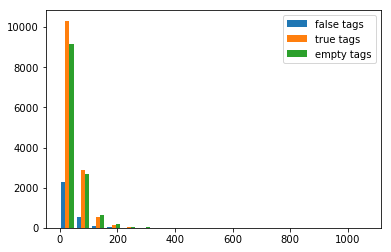

In [22]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.hist([count_false, count_true, count_empty], bins = 20, label=['false tags', 'true tags', 'empty tags'])
axes.legend(prop={'size': 10})

On observe que la longueur des questions n'est pas le facteur premier pour déterminé si on va trouver un tag à cette question, les distributions sont approximativement similaire.

On peut essayer de voir la moyenne de mots por chacune de ces catégories:

In [23]:
print(count.mean())
print(count_true.mean())
print(count_false.mean())
print(count_empty.mean())

44.4788206818
43.9157608696
40.5976470588
45.9975756628


Une nouvelle fois: pas vraiment de différences entre ces différentes catégories.

On peut maintenant observer le taux d'erreurs que l'on fait pour chacune de ces catégories:

In [24]:
print(len(TRUE_TAGS_ARG))
print(len(FALSE_TAGS_ARG))
print(len(EMPTY_TAGS_ARG))

13984
2975
12787


On fait peu d'erreurs mais on arrive pas souvent à retourner un tag.

On va observer les mêmes conclusions pour les autres algorithmes présentés précédemment. Nous allons présentés les réultats ici car les temps de compilations sont très longs:

|Algorithme| TRUE | FALSE | EMPTY |
| ------------- | -------------| --------- |
|Random Forest|46%|12%|42%|
|Logistic Regression|44%|15%|40%|
|Extra Trees|33%|4%|62%|
|Voting Classifier|43%|6%|40%|

**NB**: Nous avons fait voter les classifieurs étudier précédemment pour voir si les résultats pouvaient être amélioré ce qui n'est pas le cas.

**Solution**: Lorsque nous voudrons proposer un taguage nous allons tout d'abord observer si l'algorithme extra trees (taux d'erreurs le plus faible) nous renvoie un tag si ce n'est pas le cas, nous allons observer si le random forest nous renvoie un tag, sinon nous utiliserons la régression logistique. De cette manière on diminue un peu le fait de ne retourner aucun tag et nous garderons une erreur la plus faible possible.

### Test de la solution

In [10]:
import numpy as np
y_pred = []
for i in range(0, len(y_pred_extra_trees)):
    if sum(y_pred_extra_trees[i,:]) == 0:
        if sum(y_pred_lr[i,:]) == 0:
            y_pred.append(y_pred_forest[i,:])
        else:
            y_pred.append(y_pred_lr[i,:])
    else:
        y_pred.append(y_pred_extra_trees[i,:])
y_pred = np.array(y_pred)         

In [11]:

x = np.concatenate([y_pred[:,:29], 0*np.ones((len(y_pred), 1)), y_pred[:,29:]], axis=1)
tags_pred = multilabel_binarizer.inverse_transform(np.array(x))
x = np.concatenate([y_test[:,:29], 0*np.ones((len(y_test), 1)), y_test[:,29:]], axis=1)
tags_test = multilabel_binarizer.inverse_transform(np.array(x))

from collections import defaultdict
tags_values = defaultdict(int)
for i in range(0, len(tags_test)):
    if len(tags_pred[i]) == 0:
        tags_values[i] = -1
    else:
        for tag in tags_pred[i]:
            if tag in tags_test[i]:
                tags_values[i] = 1
            else:
                tags_values[i] = 0
                break
                
x =  np.array(list(tags_values.values()))
keys =  np.array(list(tags_values.keys()))
TRUE_TAGS_ARG = keys[x == 1]
FALSE_TAGS_ARG = keys[x == 0]
EMPTY_TAGS_ARG = keys[x == -1]
print(len(TRUE_TAGS_ARG))
print(len(FALSE_TAGS_ARG))
print(len(EMPTY_TAGS_ARG))

15665
4903
9178


On a maintenant 54% des tags qui sont corrects, 30% sans prédictions et 16% avec des erreurs. On a des tags corrects 10% de fois en plus ce qui est déjà très satisfaisant! L'erreur est quasiment la même que pour le random forest et on est incapable de prédire des tags 30% du temps.

## Conclusion

Nous avons dans cette partie essayer de prédire des tags à partir d'un corpus de questions stackoverflows avec leurs titres. Nous avons tout d'abord tester des méthodes non supervisés qui se sont avérés être des méthodes peu précises pour prédire des tags. Nous nous sommes alors tourner vers un taguage supervisé qui lui apporte des résultats bien meilleurs.

Après avoir tester quelques algorithmes de classification supervisé à sorties multiples, nous avons essayer d'élaborer une méthode pour améliorer nos résultats. Compte tenu du problème en question qui est d'essayer d'aider les utilisateurs à taguer leurs questions nous avons décider que ce que nous voulions éviter était principalement les tags faux et les retours nuls. 

Nous avons alors décider de faire tourner les algorithmes les uns après les autres en faisant priorité aux algorithmes qui affichaient le moins d'erreur. Nous nous contentons donc de récupérer le résultat d'un algorithme extra-trees, puis d'une régression logistique puis d'une forêt aléatoire.

Nous obtenons un résultat satisfaisant: plus de 50% des tags prédits sont bons, 16% sont faux et le reste n'est pas prédit. Il reste cependant de nombreuses améliorations sur lesquelles ont pourra potentiellement travailler pour améliorer les résultats comme: 
- choisir un dictionnaire plus pertinent en sélectionnant les mots à la main parmi les mots avec la plus grande occurence pour obtenir de meilleurs features et du coup améliorer le résultat de nos algorihtmes.
- tester l'augmentation de la taille de nos échantillons d'entrainement et de tests pour savoir si on peut avoir de meilleurs résultats avec un plus gros volume de données (on avait ici près de 200 000 questions ce qui est déjà très volumineux vis à vis de la puissance de calcul à disposition: 8Go de RAM)
- augmenter le nombre d'algorithmes en essayant de garder des algorithmes qui ont approximativement les mêmes résultats que le random forest ou mieux ce qui nous permettrait comme on l'a vu de combiner les résultats de manière intelligente et ainsi encore améliorer nos résultats.
- on pourrait également s'intéresser aux tags prédits faux: on a fait ici que compter les tags qui sont faux mais on pourrait essayer d'évaluer à quel point la prédiction est fausse: le tag "C" est une erreur moins importante si le tag à prédire était "C++" que si on avait prédit le tag "database". On pourrait essayer d'introduire une notion de distance entre les tags pour mieux apprécier l'erreur que l'on commet réellement.

Ces améliorations n'ont pas été mis en place mais nous avons tout de même essayer d'apporter une solution satisfaisante à ce problème de taguage des questions stack overflows.